# https://en.wikipedia.org/wiki/Collaborative_filtering

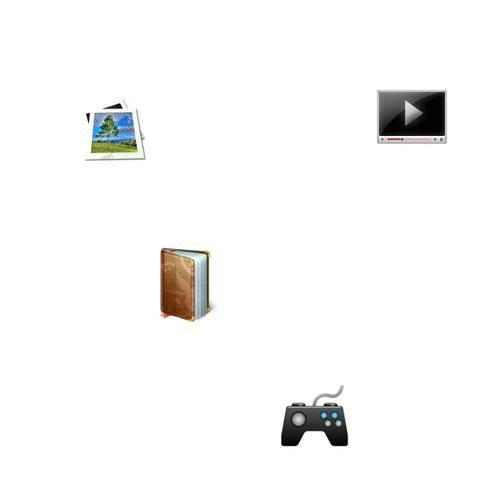

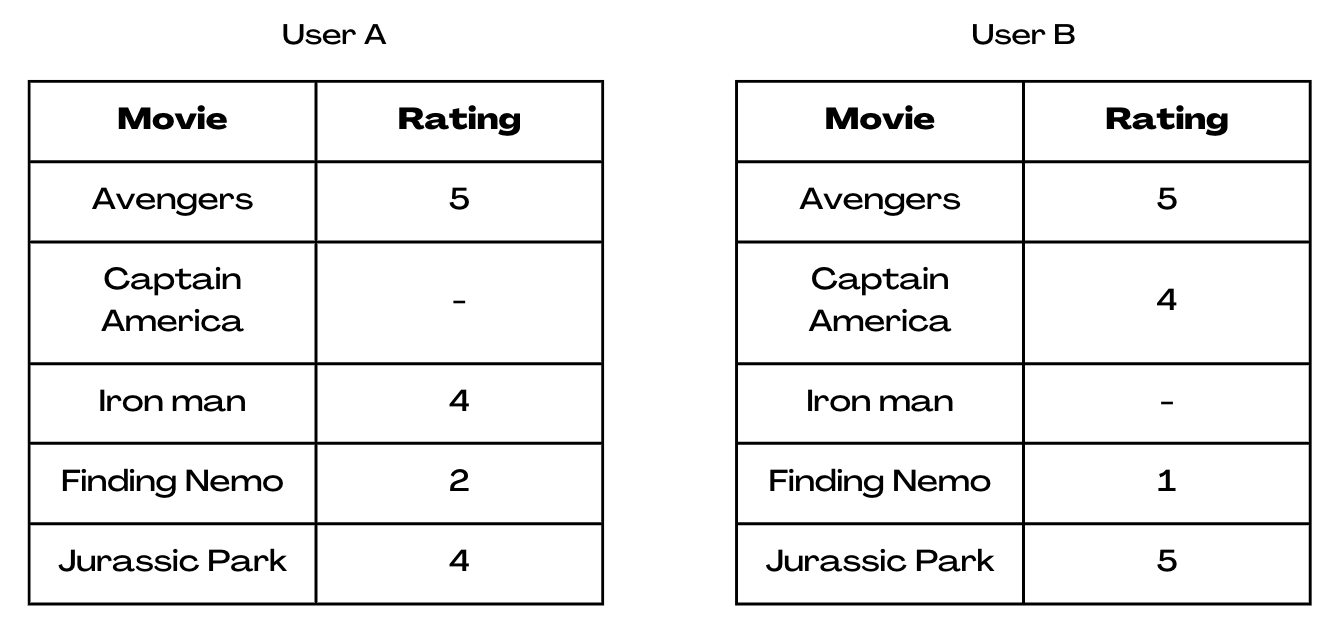

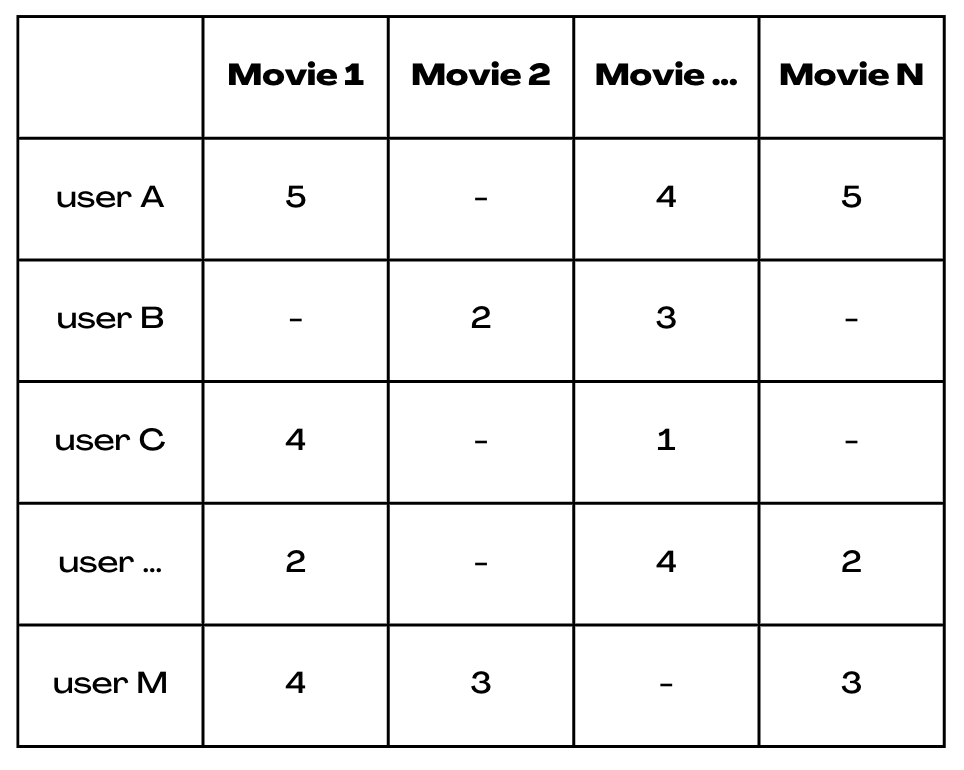

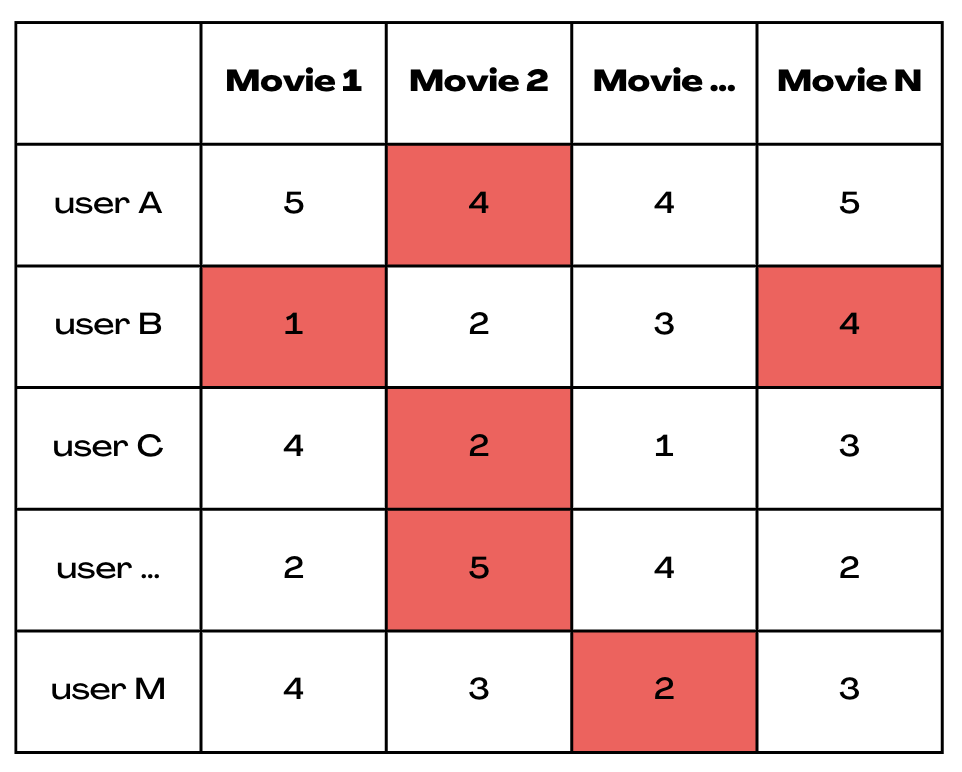

In [3]:
from pyspark.sql import (
    functions as f,
    SparkSession,
    types as t
)
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

# more dataset available: https://gist.github.com/entaroadun/1653794

# https://spark.apache.org/docs/latest/ml-collaborative-filtering.html
spark = SparkSession.builder.appName("ml_als_sample").getOrCreate()

# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.recommendation.ALS.html
# Alternating Least Squares (ALS) matrix factorization.
# Collaborative Filtering approach
df = spark.read.csv(
    "file:///home/jovyan/work/sample/sample_movie_lens.csv",
    header=True, inferSchema=True)
df.show()

+-------+--------+------+---------+
|user_id|movie_id|rating|timestamp|
+-------+--------+------+---------+
|    196|     242|     3|881250949|
|    186|     302|     3|891717742|
|     22|     377|     1|878887116|
|    244|      51|     2|880606923|
|    166|     346|     1|886397596|
|    298|     474|     4|884182806|
|    115|     265|     2|881171488|
|    253|     465|     5|891628467|
|    305|     451|     3|886324817|
|      6|      86|     3|883603013|
|     62|     257|     2|879372434|
|    286|    1014|     5|879781125|
|    200|     222|     5|876042340|
|    210|      40|     3|891035994|
|    224|      29|     3|888104457|
|    303|     785|     3|879485318|
|    122|     387|     5|879270459|
|    194|     274|     2|879539794|
|    291|    1042|     4|874834944|
|    234|    1184|     2|892079237|
+-------+--------+------+---------+
only showing top 20 rows



In [4]:
# split 80% 20%
(training, test) = df.randomSplit([0.8, 0.2])

In [5]:
# maxIter: maximum number of iterations to run, default 10
# regParam: specifies the regularization parameter, default 1.0
# coldStartStrategy: drop if the prediction is NaN
# nonnegative: specifies whether or not to use nonnegative constraints for least squares (defaults to false).
als = ALS(
        maxIter=5,
        regParam=0.01, 
        userCol="user_id",
        itemCol="movie_id",
        ratingCol="rating",
        coldStartStrategy="drop",
        nonnegative=True)

model = als.fit(training)

In [8]:
# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
predictions.show()

+-------+--------+------+---------+----------+
|user_id|movie_id|rating|timestamp|prediction|
+-------+--------+------+---------+----------+
|     26|     258|     3|891347949| 1.9924822|
|     44|     195|     5|878347874|0.92892134|
|     13|      98|     4|881515011| 1.2126861|
|    292|     174|     5|881105481|  4.679006|
|    268|       2|     2|875744173|   2.09627|
|    286|     379|     5|877533771|0.22018108|
|     59|      23|     5|888205300| 0.4357624|
|    130|    1014|     3|876250718|0.42417195|
|    194|      54|     3|879525876|0.33416638|
|    194|     274|     2|879539794|0.35935372|
|    293|     471|     3|888904884|0.26609397|
|     82|     135|     3|878769629| 2.1336634|
|     62|     382|     3|879375537|  4.022566|
|    213|     172|     5|878955442| 1.0770218|
|    119|     237|     5|874775038|0.47197175|
|    119|     328|     4|876923913| 1.6143936|
+-------+--------+------+---------+----------+



In [9]:
evaluator = RegressionEvaluator(
                metricName="rmse",
                labelCol="rating",
                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 2.920153550827914


In [19]:
# Generate top 10 movie recommendations for each user
userRecs = model.recommendForAllUsers(10)
userRecs.show()

+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|      1|[{143, 7.510105},...|
|      5|[{10, 3.4776294},...|
|      6|[{483, 5.741793},...|
|      7|[{237, 4.9076157}...|
|      8|[{10, 9.211628}, ...|
|     10|[{339, 4.778367},...|
|     11|[{427, 4.3973327}...|
|     13|[{360, 3.9991264}...|
|     14|[{98, 2.9993558},...|
|     15|[{304, 2.6403308}...|
|     18|[{258, 5.590705},...|
|     19|[{10, 5.3082676},...|
|     20|[{483, 6.2092743}...|
|     22|[{98, 2.7046375},...|
|     25|[{237, 5.760479},...|
|     26|[{143, 3.7584102}...|
|     28|[{220, 4.0017695}...|
|     32|[{483, 3.2795498}...|
|     36|[{339, 4.9994154}...|
|     41|[{143, 4.789412},...|
+-------+--------------------+
only showing top 20 rows



In [20]:
# Generate top 10 user recommendations for each movie
movieRecs = model.recommendForAllItems(10)
movieRecs.show()

+--------+--------------------+
|movie_id|     recommendations|
+--------+--------------------+
|       1|[{216, 5.449312},...|
|       2|[{54, 3.8214068},...|
|       4|[{216, 7.4251065}...|
|       5|[{293, 2.9972045}...|
|      10|[{94, 9.939141}, ...|
|      11|[{292, 4.9975157}...|
|      14|[{291, 6.782891},...|
|      15|[{243, 2.9971778}...|
|      16|[{291, 11.947495}...|
|      20|[{216, 5.241225},...|
|      21|[{291, 8.343085},...|
|      23|[{291, 6.495106},...|
|      25|[{162, 3.9974113}...|
|      26|[{216, 3.5437255}...|
|      29|[{216, 3.5437255}...|
|      32|[{291, 8.414445},...|
|      40|[{291, 4.9861283}...|
|      51|[{299, 3.7529511}...|
|      54|[{299, 3.204147},...|
|      56|[{301, 3.9971035}...|
+--------+--------------------+
only showing top 20 rows



In [24]:
# Generate top 10 movie recommendations for a specified set of users
users = df.select(als.getUserCol()).distinct().limit(3)
users.show()

# recommendForUserSubset(dataset, numItems)
userSubsetRecs = model.recommendForUserSubset(users, 10)
userSubsetRecs.show()

+-------+
|user_id|
+-------+
|    148|
|    243|
|    251|
+-------+

+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|    243|[{480, 7.655185},...|
|    148|[{408, 4.998643},...|
+-------+--------------------+



In [26]:
# Generate top 10 user recommendations for a specified set of movies
movies = df.select(als.getItemCol()).distinct().limit(3)
movies.show()
movieSubSetRecs = model.recommendForItemSubset(movies, 10)
movieSubSetRecs.show()

+--------+
|movie_id|
+--------+
|     496|
|     471|
|     392|
+--------+

+--------+--------------------+
|movie_id|     recommendations|
+--------+--------------------+
|     471|[{299, 6.4032974}...|
+--------+--------------------+

